In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model

In [2]:
# Transaction costs and leverage settings
transaction_cost = 0.001  # 0.1% per trade, simulates the cost of executing a trade, which is crucial in real-world trading
leverage = 2  # Leverage allows you to control a larger position with a smaller amount of capital, increasing both potential returns and risks

In [3]:
# Generate random price data
np.random.seed(42)
dates = pd.date_range(start="2023-01-01", periods=500)
prices = np.cumsum(np.random.randn(500)) + 100  # Simulated mean-reverting price data, mean-reversion suggests that prices tend to revert to a long-term average

In [4]:
# Create a DataFrame
df = pd.DataFrame({'Date': dates, 'Price': prices})
df.set_index('Date', inplace=True)

In [5]:
# Calculate rolling mean and rolling standard deviation
rolling_mean = df['Price'].rolling(window=20).mean()  # 20-day rolling average of prices
rolling_std = df['Price'].rolling(window=20).std()    # 20-day rolling standard deviation of prices

In [6]:
# Calculate Z-score
df['Z-score'] = (df['Price'] - rolling_mean) / rolling_std  # Z-score measures how many standard deviations the price is from the rolling mean

In [7]:
# Moving averages (crossover filter)
short_ma = df['Price'].rolling(window=10).mean()  # Short-term moving average (10-day)
long_ma = df['Price'].rolling(window=50).mean()   # Long-term moving average (50-day)

In [8]:
# Define trading strategy with transaction costs and moving average filter
df['Signal'] = 0
df.loc[(df['Z-score'] > 1) & (short_ma > long_ma), 'Signal'] = -1  # Short when Z-score > 1 and short MA > long MA (price is high and trend is downward)
df.loc[(df['Z-score'] < -1) & (short_ma < long_ma), 'Signal'] = 1  # Long when Z-score < -1 and short MA < long MA (price is low and trend is upward)

In [9]:
# Simulate returns
df['Returns'] = df['Price'].pct_change()  # Daily returns of the asset
df['Strategy Returns'] = df['Signal'].shift(1) * df['Returns'] * leverage  # Strategy returns with leverage applied
df['Strategy Returns'] -= transaction_cost * df['Signal'].diff().abs()  # Deduct transaction costs when position changes

In [10]:
# Cumulative returns
df['Cumulative Market Returns'] = (1 + df['Returns']).cumprod()  # Cumulative returns of the market (buy-and-hold strategy)
df['Cumulative Strategy Returns'] = (1 + df['Strategy Returns']).cumprod()  # Cumulative returns of the strategy

In [11]:
# Calculate drawdown
df['Drawdown'] = df['Cumulative Strategy Returns'] / df['Cumulative Strategy Returns'].cummax() - 1  # Drawdown measures the peak-to-trough decline during a specific period

In [12]:
# Print key statistics
print("Final Cumulative Market Returns:", df['Cumulative Market Returns'].iloc[-1])
print("Final Cumulative Strategy Returns:", df['Cumulative Strategy Returns'].iloc[-1])
print("Average Z-score:", df['Z-score'].mean())
print("Number of Trades:", df['Signal'].diff().abs().sum())  # Number of trades, determined by the number of changes in the trading signal
print("Strategy Total Return:", df['Strategy Returns'].sum())
print("Max Drawdown:", df['Drawdown'].min())  # The worst drawdown experienced by the strategy

Final Cumulative Market Returns: 1.0290783949101403
Final Cumulative Strategy Returns: 1.0873995039688378
Average Z-score: 0.02275903080175597
Number of Trades: 78.0
Strategy Total Return: 0.11285443263162609
Max Drawdown: -0.19396189310490608


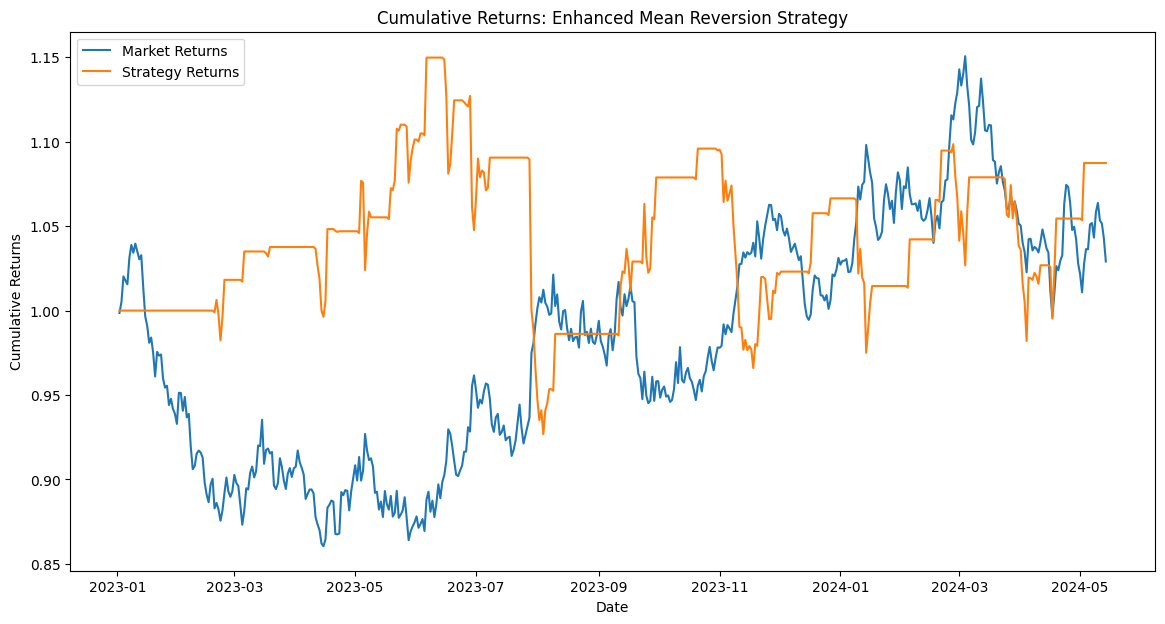

In [13]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Cumulative Market Returns'], label='Market Returns')
plt.plot(df.index, df['Cumulative Strategy Returns'], label='Strategy Returns')
plt.title('Cumulative Returns: Enhanced Mean Reversion Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

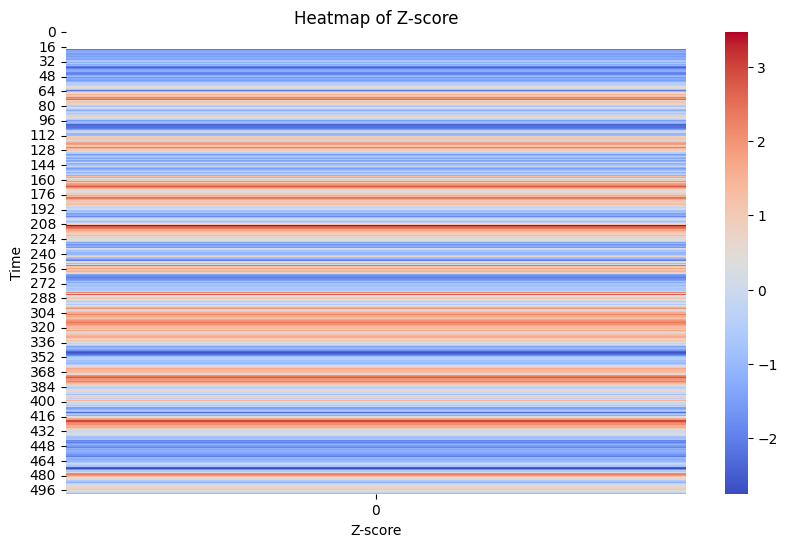

In [14]:
# Plot heatmap of Z-score
plt.figure(figsize=(10, 6))
sns.heatmap(df['Z-score'].values.reshape(-1, 1), cmap='coolwarm', cbar=True)
plt.title('Heatmap of Z-score')
plt.xlabel('Z-score')
plt.ylabel('Time')
plt.show()

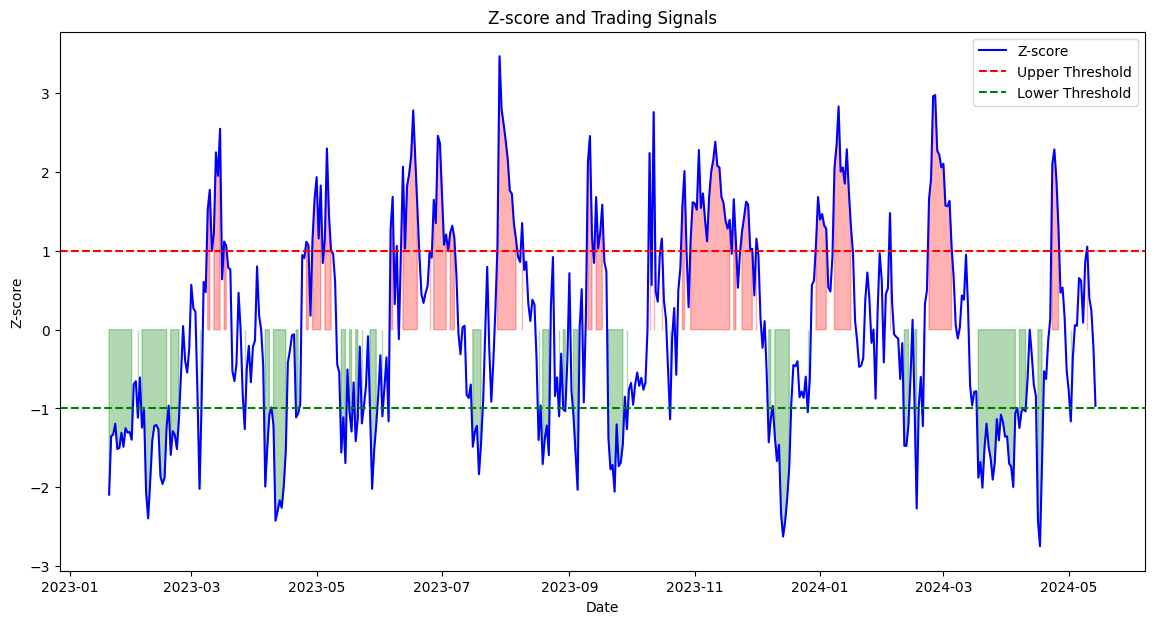

In [15]:
# Plot Z-score and signals
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Z-score'], label='Z-score', color='blue')
plt.axhline(1, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(-1, color='green', linestyle='--', label='Lower Threshold')
plt.fill_between(df.index, df['Z-score'], where=df['Z-score'] > 1, color='red', alpha=0.3)
plt.fill_between(df.index, df['Z-score'], where=df['Z-score'] < -1, color='green', alpha=0.3)
plt.title('Z-score and Trading Signals')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.show()

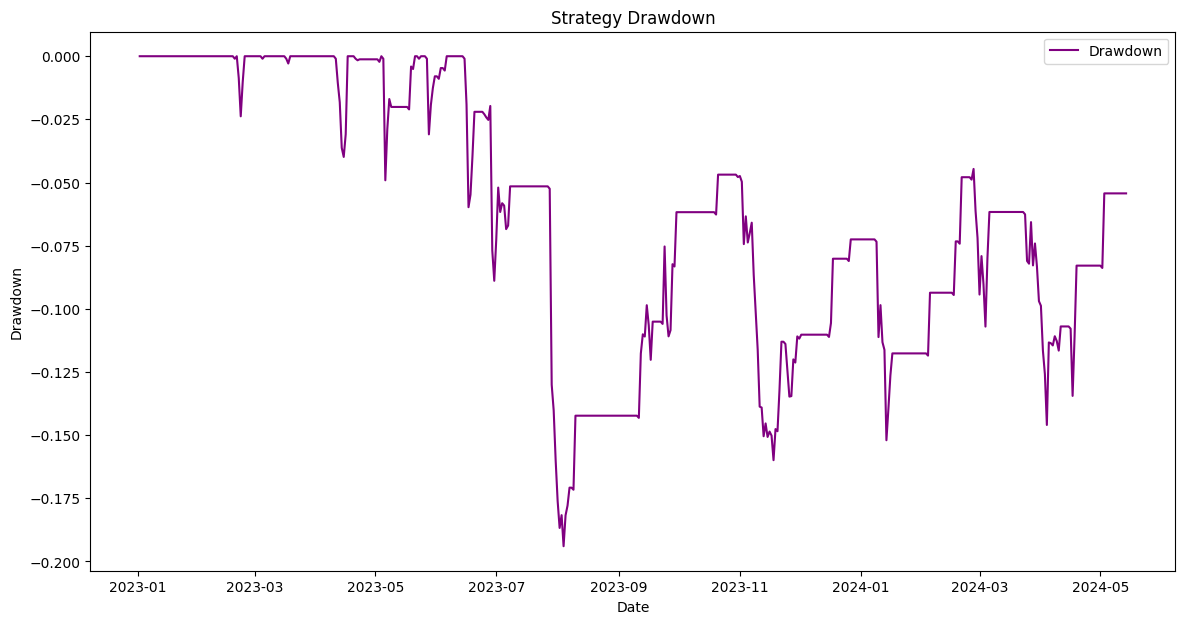

In [16]:
# Plot drawdown
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Drawdown'], label='Drawdown', color='purple')
plt.title('Strategy Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()

In [17]:
# Rescale the returns by multiplying by 100
df['Rescaled Returns'] = df['Returns'] * 100

In [18]:
# Fit GARCH(1,1) model on rescaled returns
garch_model = arch_model(df['Rescaled Returns'].dropna(), vol='Garch', p=1, q=1)
garch_fitted = garch_model.fit(disp='off')

In [19]:
# Forecast volatility for rescaled returns
df['Rescaled Volatility'] = garch_fitted.conditional_volatility

In [20]:
# Calculate Z-score using GARCH-based volatility on rescaled returns
df['GARCH Z-score'] = (df['Price'] - rolling_mean) / df['Rescaled Volatility']

In [21]:
# Define a new trading strategy based on GARCH Z-score
df['Signal GARCH'] = 0
df.loc[(df['GARCH Z-score'] > 1) & (short_ma > long_ma), 'Signal GARCH'] = -1
df.loc[(df['GARCH Z-score'] < -1) & (short_ma < long_ma), 'Signal GARCH'] = 1

In [22]:
# Simulate GARCH-based strategy returns with the original scale
df['GARCH Strategy Returns'] = df['Signal GARCH'].shift(1) * df['Returns'] * leverage
df['GARCH Strategy Returns'] -= transaction_cost * df['Signal GARCH'].diff().abs()

In [23]:
# Cumulative returns of GARCH-based strategy
df['Cumulative GARCH Strategy Returns'] = (1 + df['GARCH Strategy Returns']).cumprod()

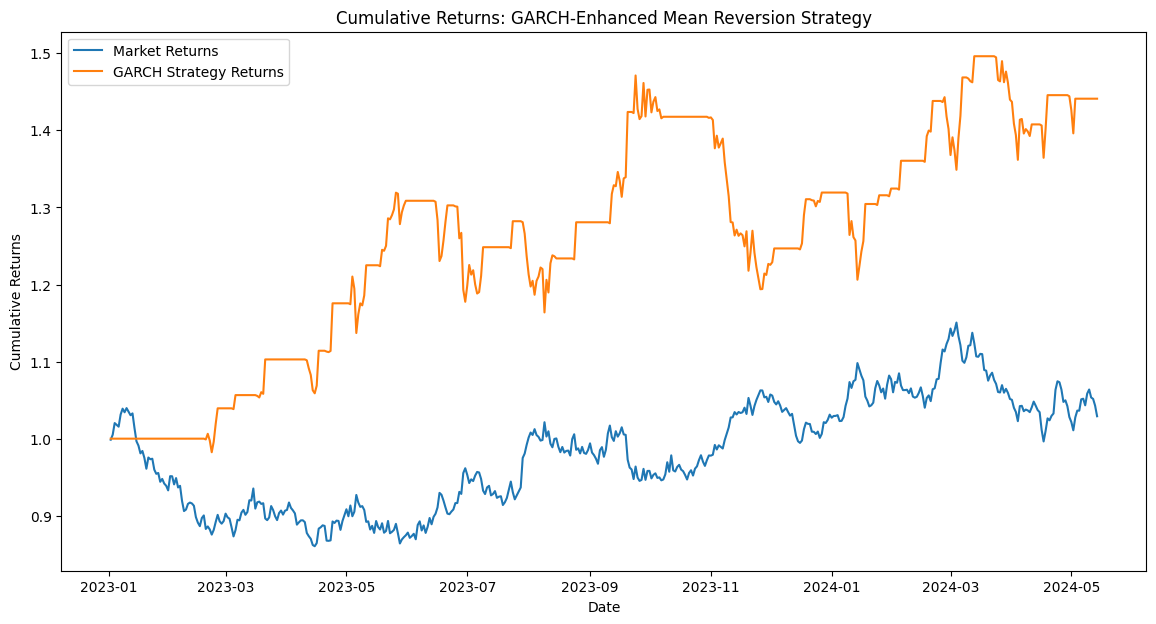

In [24]:
# Plot GARCH-based strategy returns
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Cumulative Market Returns'], label='Market Returns')
plt.plot(df.index, df['Cumulative GARCH Strategy Returns'], label='GARCH Strategy Returns')
plt.title('Cumulative Returns: GARCH-Enhanced Mean Reversion Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [25]:
# Print GARCH model summary
print(garch_fitted.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:       Rescaled Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -706.200
Distribution:                  Normal   AIC:                           1420.40
Method:            Maximum Likelihood   BIC:                           1437.25
                                        No. Observations:                  499
Date:                Thu, Aug 15 2024   Df Residuals:                      498
Time:                        11:30:08   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0106  4.440e-02      0.238      0.812 

In [26]:
# Extract and print key GARCH model parameters
garch_params = garch_fitted.params
print("\nGARCH Model Parameters:")
print(garch_params)


GARCH Model Parameters:
mu          0.010564
omega       0.067642
alpha[1]    0.000000
beta[1]     0.932261
Name: params, dtype: float64


In [27]:
# Print the last few values of the rescaled volatility forecast
print("\nLast few values of the Rescaled Volatility forecast:")
print(df['Rescaled Volatility'].tail())


Last few values of the Rescaled Volatility forecast:
Date
2024-05-10    0.999284
2024-05-11    0.999284
2024-05-12    0.999284
2024-05-13    0.999284
2024-05-14    0.999284
Name: Rescaled Volatility, dtype: float64


In [28]:
# Print the last few values of the GARCH Z-score
print("\nLast few values of the GARCH Z-score:")
print(df['GARCH Z-score'].tail())


Last few values of the GARCH Z-score:
Date
2024-05-10    1.859142
2024-05-11    0.701159
2024-05-12    0.415787
2024-05-13   -0.357488
2024-05-14   -1.513100
Name: GARCH Z-score, dtype: float64


In [29]:
# Print final cumulative GARCH strategy returns
print("\nFinal Cumulative GARCH Strategy Returns:")
print(df['Cumulative GARCH Strategy Returns'].iloc[-1])



Final Cumulative GARCH Strategy Returns:
1.4410737734626407
